# RoC Analysis Random Forest

## Data Generation
* Fix a beta* value and number of predictors
* Create a Y vector using Bernoulli distribution for logit
* Create a X vector using normal distribution as i.i.ds

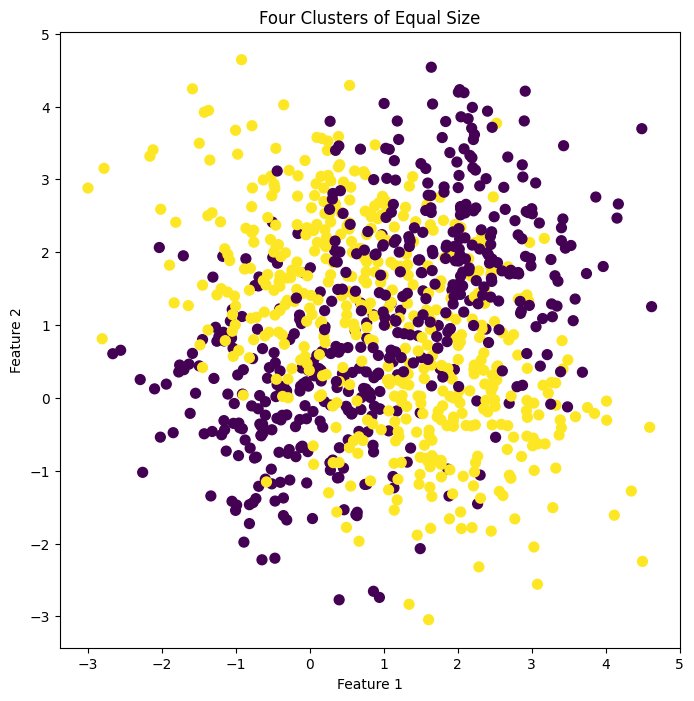

Training data shape: (800, 2), (800,)
Test data shape: (200, 2), (200,)


In [32]:
no_predictors = 2
no_samples = 1000
no_classes = 2
#kerneltype = 'linear'  #comment out for polynomial kernel
#kerneltype = 'poly'  #comment out for linear kernel

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

n_samples_per_cluster = 250
n_clusters = 4

# Create the clusters deterministically
np.random.seed(0) # for reproducibility

X = np.zeros((n_samples_per_cluster * n_clusters, 2))
y = np.zeros(n_samples_per_cluster * n_clusters)

# Cluster centers in corners of a square
centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

# Assign points to clusters deterministically
for i in range(n_clusters):
    cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
    X[cluster_indices] = centers[i] + np.random.normal(scale=1, size=(n_samples_per_cluster, 2))
    if i == 0 or i == 3:
        y[cluster_indices] = 0
    else:
        y[cluster_indices] = 1



#Visualize
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
plt.title('Four Clusters of Equal Size')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

#add intercept to X
#X = np.hstack((np.ones((X.shape[0], 1)), X))

# # shuffle data
# permutation = np.random.permutation(no_samples)
# X = X[permutation]
# y = y[permutation]


#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")





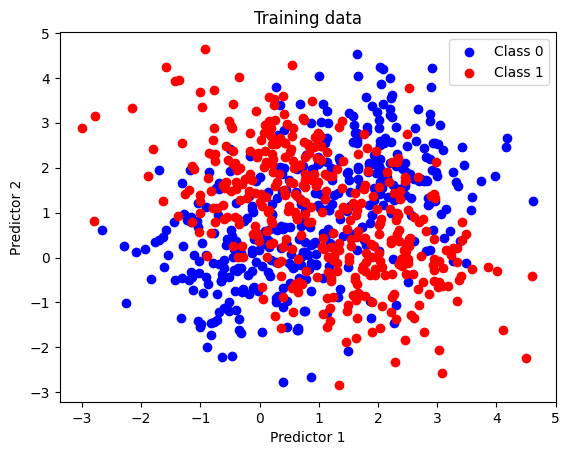

In [33]:
plt.figure()
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='b', label='Class 0') 
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Training data')
plt.show()

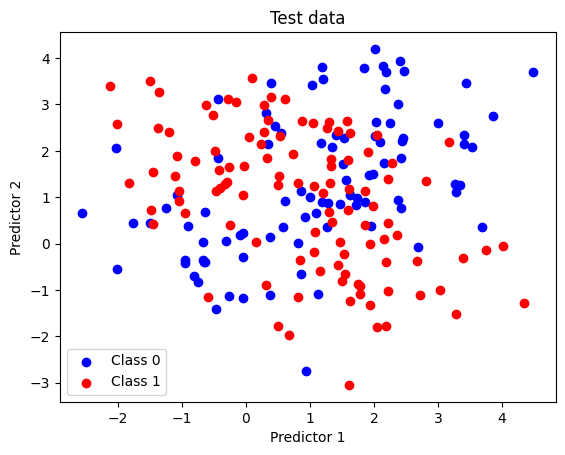

In [34]:
plt.figure()
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='b', label='Class 0') 
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Test data')
plt.show()

## Random Forest based classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

## Standard RoC curve

Length of threshold prc 84
Length of threshold_roc 74


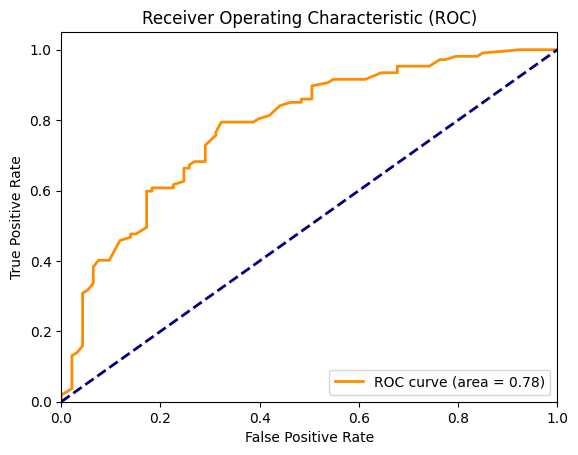

In [36]:
# Plot the RoC curve
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
precision_prc, recall_prc, threshold_prc = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

print("Length of threshold prc", len(threshold_prc))
print("Length of threshold_roc", len(threshold_roc))

roc_auc = auc(fpr_roc, tpr_roc)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## RoC curve by cost-sensitive learning

The following function fixes the threshold value. The input model to the function will be weighted in order to have the bias towards the minority class

In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_pred = clf_model.predict(X_test) # predict directly

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





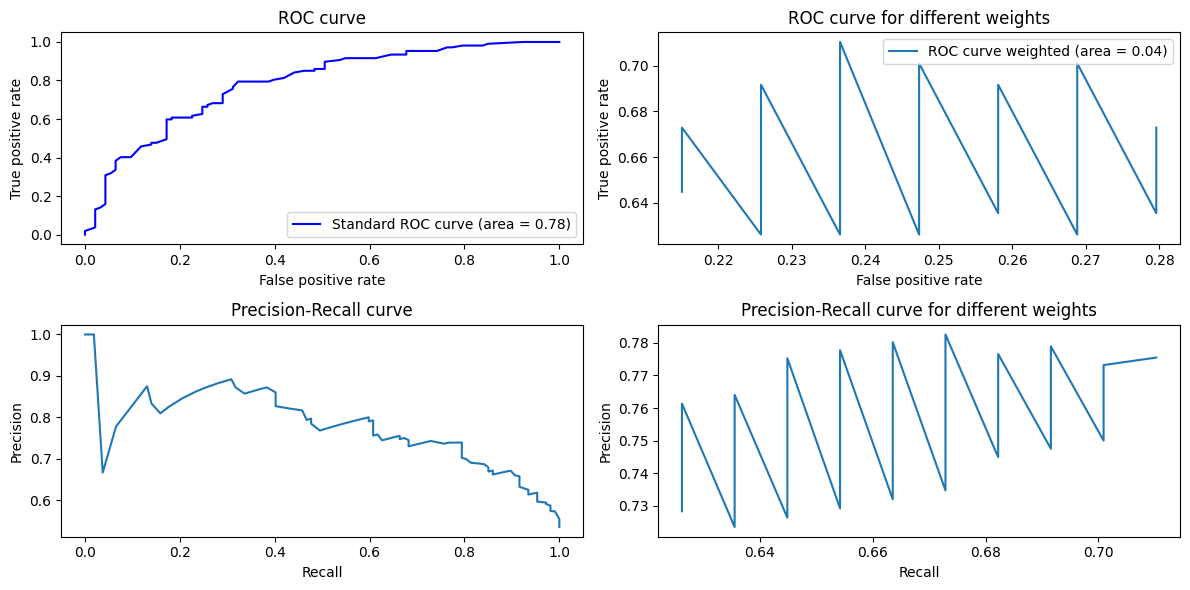

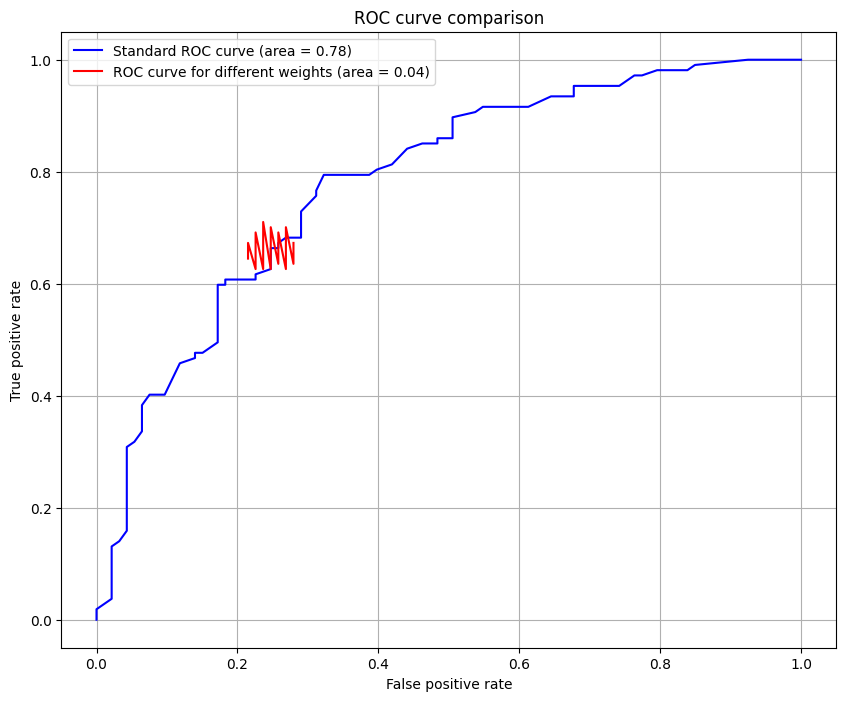

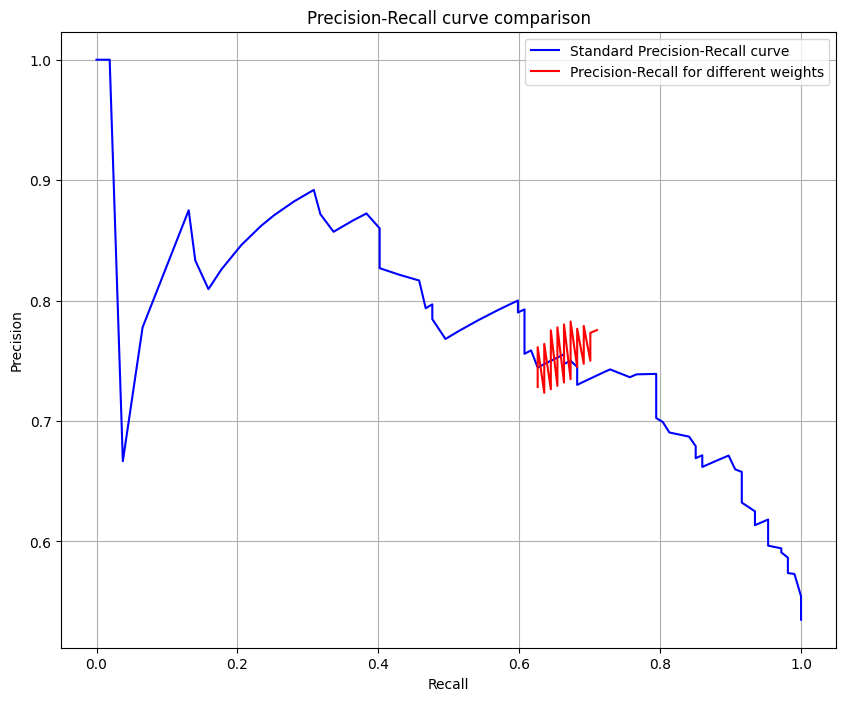

In [39]:
# Weight the X_train and y_train for cost-sensitive learning
minority_class_weight = np.arange(1,len(y_train),1)
#majority_class_weight = 1.0 - minority_class_weight
dict_weighted_clfs = {}
for w in minority_class_weight:
    class_weights = {0: len(y_train)/(no_classes*w), 1: len(y_train)/(no_classes*(len(y_train)-w)) }
    clf_weighted = RandomForestClassifier(class_weight=class_weights, random_state=42)
    clf_weighted.fit(X_train, y_train)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()


### Analysis of the beta values

The current belief is that the $\beta_0$ values should remain constant for both the RoC curve estimates. Now we will plot the log-odds graph of the different estimates.

/tmp/ipykernel_2145/1482532912.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/tmp/ipykernel_2145/1482532912.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/tmp/ipykernel_2145/1482532912.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/tmp/ipykernel_2145/1482532912.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/tmp/ipykernel_2145/1482532912.py:24: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matp

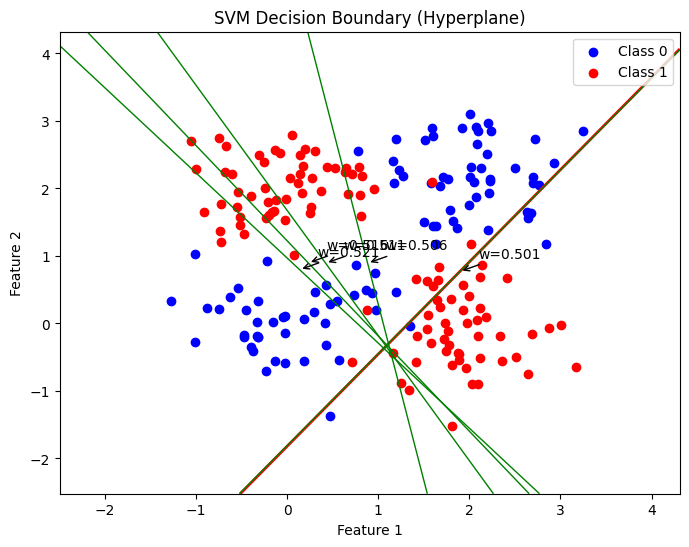

In [11]:
# Create meshgrid
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Get decision function values
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary (hyperplane)
plt.figure(figsize=(8, 6))
#plt.contourf(xx, yy, Z, alpha=0.8, cmap='RdBu')  # Fill the regions
plt.contour(xx, yy, Z, levels=[0], colors=['r'], linewidths=2)  # Hyperplane

for index in range(0, len(minority_class_weight), 10):
    w = minority_class_weight[index]
    Z = dict_weighted_clfs[w]["model"].decision_function(
                np.c_[xx.ravel(), yy.ravel()]
            )
    Z = Z.reshape(xx.shape)
    contour = plt.contour(xx, yy, Z, levels=[0], colors=["g"], linewidths=1)  # Hyperplane
    # Annotate the line with the 'w' value
    # Find a suitable position for the annotation
    if contour.collections and contour.collections[0].get_paths():
        path = contour.collections[0].get_paths()[0]
        vertices = path.vertices
        center = vertices[len(vertices) // 2]
        plt.annotate(
            f"w={w}",
            xy=center,
            xytext=(center[0]+0.2, center[1]+0.2),
            textcoords="data",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3")
        )
    else:
        #do nothing
        pass
        #print(f"Warning: No contour line found at level 0 for w={w}. Skipping annotation.")


# Plot data points
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='b', label='Class 0') 
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='r', label='Class 1') 

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary (Hyperplane)')
plt.legend()
plt.show()

## Vary the intercept

In [49]:
# calculate the decision function out of each model and print its max and min
min_Z = np.zeros(len(minority_class_weight))
max_Z = np.zeros(len(minority_class_weight))
for i, w in enumerate(minority_class_weight):
    Z = dict_weighted_clfs[w]["model"].decision_function(X_test)
    min_Z[i] = np.min(Z)
    max_Z[i] = np.max(Z)
print(np.min(min_Z), np.max(min_Z))


-1.885803819544508 0.9999995130307682


In [50]:
import copy
import numpy as np
import multiprocessing as mp
from functools import partial


def process_intercept(threshold, dict_weighted_clfs, minority_class_weight, X_test, y_test):
    results_for_intercept = {}
    for w in minority_class_weight:
        # Deep copy ONLY the model being modified for this weight w
        model_copy = copy.deepcopy(dict_weighted_clfs[w]["model"]) 
        # calculate the new intercept
        intercept = dict_weighted_clfs[w]["model"].intercept_[0] - threshold
        # Modify the intercept of the copy
        try:
            model_copy.intercept_[0] = intercept
        except (AttributeError, IndexError, TypeError) as e:
            print(f"Warning: Could not set intercept for weight {w}, intercept {intercept}. Error: {e}")
            continue # Skip this model/intercept combo if setting fails

        
        metrics = get_fpr_tpr(model_copy, X_test, y_test) 

        if metrics: # Check if metrics calculation was successful
            distance = np.sqrt((metrics["fpr"] - 0)**2 + (metrics["tpr"] - 1)**2)
            results_for_intercept[w] = {
                "model": model_copy, # Store the modified model if needed, or just parameters
                "metrics": metrics,
                "distance": distance,
                "fpr": metrics["fpr"],
                "tpr": metrics["tpr"],
                "precision": metrics["precision"],
                "recall": metrics["recall"]
            }

    # Check if any results were generated for this intercept
    if not results_for_intercept:
        return (intercept, None) # Indicate failure for this intercept

    # Find the minimum distance among weights for this intercept
    min_distance = min(res["distance"] for res in results_for_intercept.values())
    min_distance_weights = [w for w, res in results_for_intercept.items() if res["distance"] == min_distance]

    # Handle ties (here, just taking the first one)
    best_w = min_distance_weights[0] 

    # Return the relevant info for the best weight found for THIS intercept
    return (intercept, {
        # Decide if you need the whole model object or just its state/parameters
        # Returning the whole object can be slow due to serialization
        "best_weight": best_w, 
        # "model_state": model_to_state(results_for_intercept[best_w]["model"]), # Example
        "metrics": results_for_intercept[best_w]["metrics"],
        "distance": results_for_intercept[best_w]["distance"],
        "fpr": results_for_intercept[best_w]["fpr"],
        "tpr": results_for_intercept[best_w]["tpr"],
        "precision": results_for_intercept[best_w]["precision"],
        "recall": results_for_intercept[best_w]["recall"]
    })

# Main code
threshold = np.arange(-2, 1, 0.1)
dict_intercept_clfs = {}

# Create a partial function with fixed arguments
process_func = partial(process_intercept, 
                       dict_weighted_clfs=dict_weighted_clfs, 
                       minority_class_weight=minority_class_weight,
                       X_test=X_test,
                       y_test=y_test)

# Set up the parallel processing with 10 cores
num_cores = 10
with mp.Pool(processes=num_cores) as pool:
    # Map the function to all intercept values and process in parallel
    results = pool.map(process_func, threshold)

# Convert results list to dictionary
dict_intercept_clfs = dict(results)

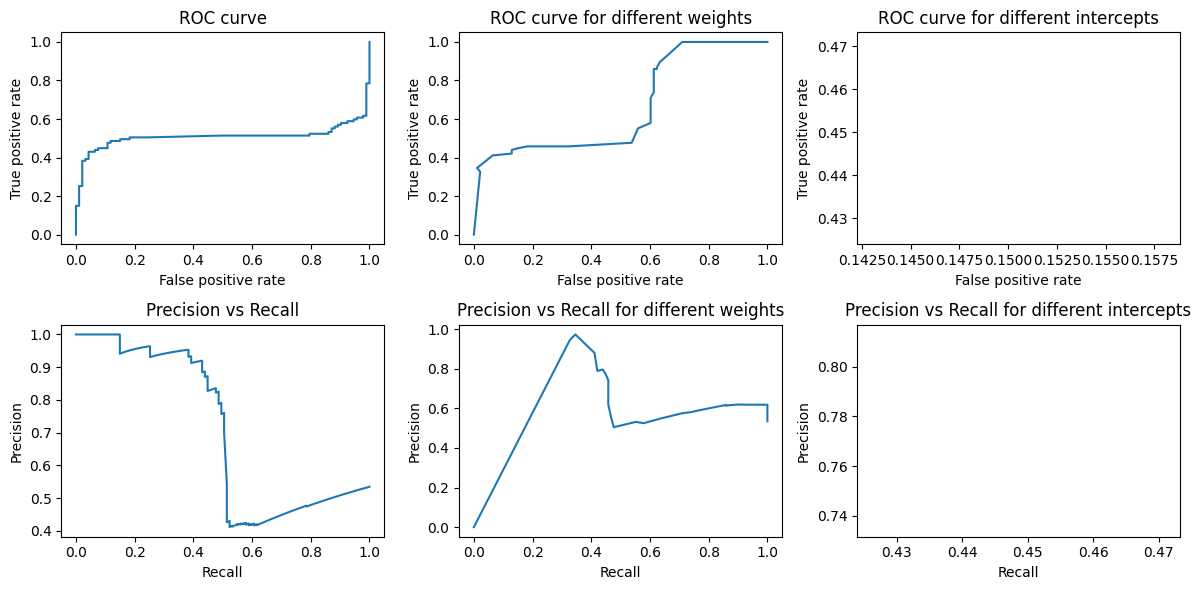

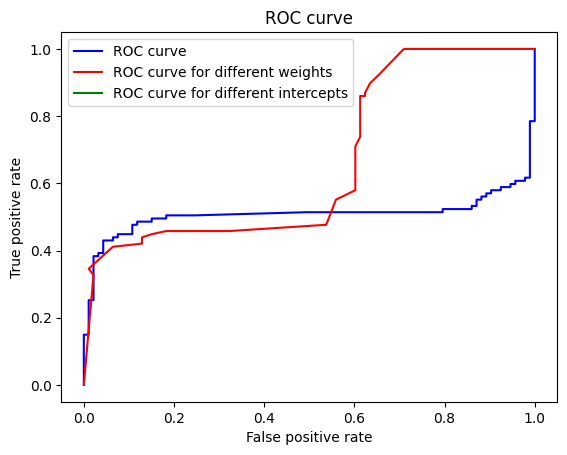

In [51]:
# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_intercept_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_intercept_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points] 

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_intercept_clfs.values()]
precision_weighted = [v["precision"] for v in dict_intercept_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc)
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][1].plot([v["fpr"] for v in dict_weighted_clfs.values()], [v["tpr"] for v in dict_weighted_clfs.values()])
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][2].plot(fpr_weighted_sorted, tpr_weighted_sorted)
ax[0][2].set_xlabel('False positive rate')
ax[0][2].set_ylabel('True positive rate')
ax[0][2].set_title('ROC curve for different intercepts')
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision vs Recall')
ax[1][1].plot([v["recall"] for v in dict_weighted_clfs.values()], [v["precision"] for v in dict_weighted_clfs.values()])
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision vs Recall for different weights')
ax[1][2].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][2].set_xlabel('Recall')
ax[1][2].set_ylabel('Precision')
ax[1][2].set_title('Precision vs Recall for different intercepts')
plt.tight_layout()
plt.show()

# Plot both the curves on the same plot figure
plt.figure()
figsize=(12, 12)
plt.plot(fpr_roc, tpr_roc, label='ROC curve',color='blue')
plt.plot([v["fpr"] for v in dict_weighted_clfs.values()], [v["tpr"] for v in dict_weighted_clfs.values()], label='ROC curve for different weights',color='red')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label='ROC curve for different intercepts',color='green')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve')
plt.show()


In [52]:
len(fpr_weighted_sorted)

30

In [53]:
min(fpr_weighted_sorted), max(fpr_weighted_sorted)

(np.float64(0.15053763440860216), np.float64(0.15053763440860216))

In [54]:
min(tpr_weighted_sorted), max(tpr_weighted_sorted)

(np.float64(0.4485981308411215), np.float64(0.4485981308411215))

## Plot the decision boundaries

### Plot the misclassification rate for all the different thresholds

## Conclusion

* 1. For the simple logistic regression function, the RoC curve either generated by changing the threshold or by changing the weights generate similar results.
* 2. Changing weights take longer to execute